# Analyse MD simulation of ice with MBAR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymbar
from watermodel import *
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


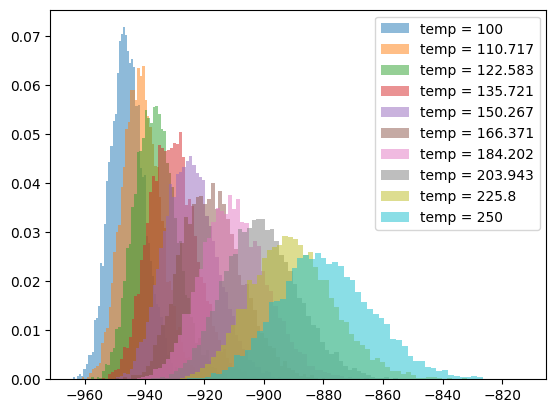

In [3]:
n_waters = 16

Tmin = 100
Tmax = 250
temp_steps = 10
temperatures = np.geomspace(Tmin, Tmax, temp_steps)

path = '/import/a12/users/minvernizzi/scratch-allegro/ice/mbar/'
path = f'{path}N{n_waters}-T{Tmin}-R{temp_steps}/'
def get_info(temp, n_waters=n_waters, ice_type='XI', water_type='tip4pew', rigidWater=True):
    info = f'ice{ice_type}_T{temp:g}_N{n_waters}'
    if water_type != 'tip4pew':
        info = f'{water_type}_{info}'
    if not rigidWater:
        info = f'flex_{info}'
    return info
model = WaterModel.load_from_json(f'{path}model-{get_info(Tmax)}.json')
num_samples = len(np.load(f'{path}MDtraj-{get_info(Tmax)}.npz')['ene'])

# positions = np.empty((temp_steps, num_samples, model.n_sites, 3))
energies = np.empty((temp_steps, num_samples))
for k,t in enumerate(temperatures):
    # data = np.load(f'{path}MDtraj-{get_info(t)}.npz')
    # positions[k], energies[k] = data['pos'], data['ene']
    energies[k] = np.load(f'{path}MDtraj-{get_info(t)}.npz')['ene']

for k,ene in enumerate(energies):
    plt.hist(ene, bins='auto', density=True, alpha=.5, label=f'temp = {temperatures[k]:g}')
plt.legend()
plt.show()

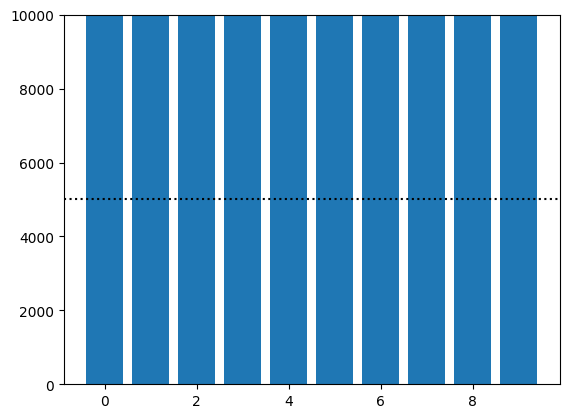

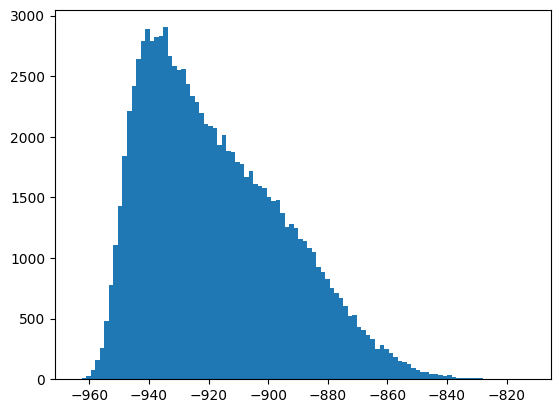

In [4]:
subsample_correlated_data = True

if subsample_correlated_data:
    N_k = np.zeros(temp_steps, dtype=int)
    all_ene = []
    for k,ene in enumerate(energies):
        indices = pymbar.timeseries.subsample_correlated_data(ene)
        all_ene.append(ene[indices])
        N_k[k] = len(indices)
    del energies
    all_ene = np.concatenate(all_ene)
else:
    N_k = np.ones(temp_steps, dtype=int) * num_samples
    all_ene = energies.flatten()

u_kn = np.empty((temp_steps, N_k.sum()))
for k,t in enumerate(temperatures):
    u_kn[k] = all_ene / (kB * t)

## some plotting
plt.bar(np.arange(temp_steps), N_k)
plt.axhline(num_samples/2, c='k', ls=':')
plt.ylim(0, num_samples)
plt.show()

plt.hist(all_ene, bins='auto')
plt.show()

In [5]:
## calculate mbar
mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=100, solver_protocol='robust')
# mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=100, initial_f_k=u_kn.mean(axis=1))

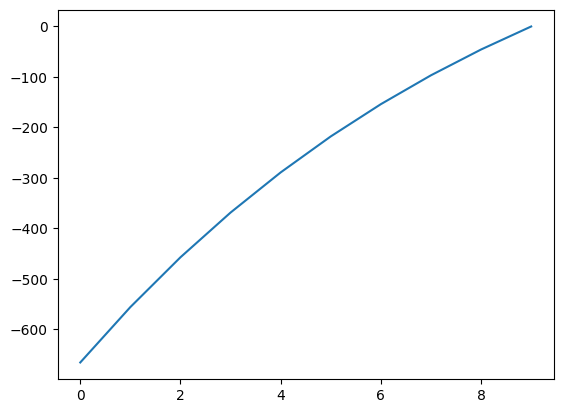

N16-T100-R10: DeltaF = -666.0325843328823 +/- 0.0208451


: 

In [6]:
results = mbar.compute_free_energy_differences(uncertainty_method="bootstrap")

## plot
plt.plot(results['Delta_f'][-1])
plt.show()

print(f"N{n_waters}-T{Tmin}-R{temp_steps}: DeltaF = {results['Delta_f'][-1,0]} +/- {results['dDelta_f'][-1,0]:g}")

estimates obtained with `pymbar.MBAR(u_kn, N_k, n_bootstraps=100, solver_protocol='robust')`

- N16-T100-R2: DeltaF = -664.8106658866524 +/- 0.759468
- N16-T100-R2-longer: DeltaF = -666.3206393027448 +/- 0.173577
- N16-T100-R10: DeltaF = -665.9966939401488 +/- 0.0318184
- N16-T100-R5:  DeltaF = -666.09897990553 +/- 0.0558899
- N16-T50-R10: DeltaF = -1818.2199636389134 +/- 0.0632776
- N16-T50-R5:  DeltaF = -1818.1037162200666 +/- 0.0999108
- N128-T100-R10: DeltaF = -5314.324317927606 +/- 0.0944014
- N128-T50-R20: DeltaF = -14522.10556489954 +/- 0.135